In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

c:\Users\mathi\anaconda3\envs\TorchGPU\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device =(
    'cuda' if torch.cuda.is_available()
    else 'cpu'
)

x = torch.tensor(3., requires_grad=True) # On track les gradients
y = torch.tensor(3., requires_grad=True)

def f(x,y): # Fonction res = x^2 + y^2
    return x**2 + y**2

lr = 1e-1

for _ in tqdm(range(200)):
    res = f(x,y) # On calcule la fonction que l'on veut minimiser avec les paramètres x et y
    res.backward() # On calcul les gradients
    with torch.no_grad(): # On ne veut pas track les gradients quand on fait la mise à jour des paramètres
        x -= lr*x.grad # lr va diminuer la maj des paramètres
        y -= lr*y.grad
    x.grad.zero_() # On reset les gradients pour ne pas les accumuler
    y.grad.zero_()

print(f'X = {x}, Y = {y}, res = {f(x,y)}') # On affiche les paramètres et le résultat de la fonction



# Donc à retenir :
# 1. On track les gradients des paramètres à optimiser
# 2. On calcule la fonction à minimiser
# 3. On calcul les gradients
# 4. On met à jour les paramètres sans tracker les gradients !!!
# 5. On reset les gradients !!! Pour pas les accumuler quand on fait appel à l'optimizer

100%|██████████| 200/200 [00:00<00:00, 5054.44it/s]

X = 1.2448552523509928e-19, Y = 1.2448552523509928e-19, res = 3.0993291652224286e-38


In [4]:
mu = 0.5
std = 0.5

transf = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mu), (std))]) # On normalise les données


train_loader = torch.utils.data.DataLoader(datasets.MNIST('.\data',
                                            train = True,
                                            transform=transf,
                                            download = True),
                                            shuffle=True,
                                            batch_size = 32)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('.\data',
                                            train = False,
                                            transform=transf,
                                            download = True),
                                            shuffle=True,batch_size = 32)


Failed to download (trying next):
<urlopen error [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]


Extracting .\data\MNIST\raw\train-images-idx3-ubyte.gz to .\data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée>



100%|██████████| 28.9k/28.9k [00:00<00:00, 276kB/s]


Extracting .\data\MNIST\raw\train-labels-idx1-ubyte.gz to .\data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée>



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.43MB/s]


Extracting .\data\MNIST\raw\t10k-images-idx3-ubyte.gz to .\data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.55MB/s]

Extracting .\data\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\data\MNIST\raw



shape du train dataset : torch.Size([60000, 28, 28])
Taille d' une image : torch.Size([1, 28, 28])


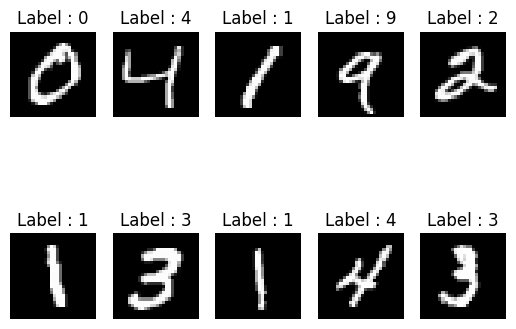

In [5]:
print (f'shape du train dataset : {train_loader.dataset.data.shape}')
print(f'Taille d\' une image : {train_loader.dataset[0][0].shape}')
data_image = train_loader.dataset.data.unsqueeze(1)
plt.figure()
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(data_image[i,0], cmap='gray')
    plt.axis('off')
    plt.title('Label : ' + str(train_loader.dataset[i][1]))


In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 10)
        self.init_weights() # Initialiser les poids de manière personalisée

    def init_weights(self):
        for p in self.parameters(): # parameters regroupe les paramètres de chaque couche donc les matrices de pois et les vecteurs de biais
            if p.ndim == 1: # parmètre de biais (dim 1)
                nn.init.normal_(p) # initialisation des biais de manière aléatoire suivant une loi normale
            else:
                nn.init.kaiming_normal_(p) # Initialisation des poids suivant la méthode de Kaiming

    def forward(self, x):
        x = x.view(-1, 28*28) # Sur torch le reshape est .view -1 on se préoccupe pas de la taille de la première dimension on change juste les 2 dernière
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x)) # On utilise softmax pour avoir une distribution de probabilité
        return x
    
model = Net()
print(model)

learning_rate = 1e-3
criterion = nn.CrossEntropyLoss() # la fonction de perte (loss) cross entropy pour les problèmes de classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Technique pour optimiser les paramètres et faire la descente de gradient

def accuracy(pred_label, label_batch):
    correct = 0
    batch_size = label_batch.shape[0]
    preds = torch.argmax(pred_label, dim=-1) # On récupère l'indice de la valeur maximale
    for i , pred in enumerate(preds):
        if pred == label_batch[i]:
            correct += 1
    return correct/batch_size
    
epoch = 10
writer = SummaryWriter()
for epochs in tqdm(range(10)):
    print(f'Epoch {epochs+1/10}')
    for batch, (data_batch,label_batch) in enumerate(train_loader): # Générateur à la place de in range
        pred_batch = model(data_batch)
        loss = criterion(pred_batch, label_batch)
        acc = accuracy(pred_batch, label_batch)
        print(f'\r batch {batch}/{60000/32}   Loss : {loss : .3}' f'Accuracy : {acc : .3}', end='') # \r va réecrire sur la même ligne donc pas 100000 lignes
        loss.backward()
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.step() # On met à jour les paramètres directement avec torch no grad
        optimizer.zero_grad() # On reset les gradients
        print('')
        loss = 0.
        acc= 0.
    writer.flush()
    for batch, (data_batch,label_batch) in enumerate(test_loader): # Générateur à la place de in range
        with torch.no_grad():
            pred_batch = model(data_batch)
            loss += criterion(pred_batch, label_batch)
            acc += accuracy(pred_batch, label_batch)
    loss /= batch
    acc /= batch
    print(f'Valid_Loss : {loss : .3} \n Valid_Accuracy : {acc : .3}') # \r va réecrire sur la même ligne donc pas 100000 lignes

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0.1
 batch 0/1875.0   Loss :  2.33Accuracy :  0.0938
 batch 1/1875.0   Loss :  2.31Accuracy :  0.125
 batch 2/1875.0   Loss :  2.28Accuracy :  0.156
 batch 3/1875.0   Loss :  2.3Accuracy :  0.156
 batch 4/1875.0   Loss :  2.27Accuracy :  0.188
 batch 5/1875.0   Loss :  2.17Accuracy :  0.312
 batch 6/1875.0   Loss :  2.25Accuracy :  0.125
 batch 7/1875.0   Loss :  2.29Accuracy :  0.156
 batch 8/1875.0   Loss :  2.27Accuracy :  0.156
 batch 9/1875.0   Loss :  2.21Accuracy :  0.25
 batch 10/1875.0   Loss :  2.21Accuracy :  0.25
 batch 11/1875.0   Loss :  2.25Accuracy :  0.188
 batch 12/1875.0   Loss :  2.25Accuracy :  0.219
 batch 13/1875.0   Loss :  2.14Accuracy :  0.312
 batch 14/1875.0   Loss :  2.13Accuracy :  0.375
 batch 15/1875.0   Loss :  2.17Accuracy :  0.312
 batch 16/1875.0   Loss :  2.12Accuracy :  0.375
 batch 17/1875.0   Loss :  2.21Accuracy :  0.281
 batch 18/1875.0   Loss :  2.04Accuracy :  0.469
 batch 19/1875.0   Loss :  2.21Accuracy :  0.281
 batch 20/1875.0   Los

C:\Users\mathi\AppData\Local\Temp\ipykernel_4876\975166707.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x)) # On utilise softmax pour avoir une distribution de probabilité


 batch 42/1875.0   Loss :  2.13Accuracy :  0.312
 batch 43/1875.0   Loss :  2.1Accuracy :  0.406
 batch 44/1875.0   Loss :  2.11Accuracy :  0.375
 batch 45/1875.0   Loss :  1.98Accuracy :  0.562
 batch 46/1875.0   Loss :  1.97Accuracy :  0.5
 batch 47/1875.0   Loss :  2.04Accuracy :  0.438
 batch 48/1875.0   Loss :  1.97Accuracy :  0.5
 batch 49/1875.0   Loss :  2.01Accuracy :  0.469
 batch 50/1875.0   Loss :  2.09Accuracy :  0.438
 batch 51/1875.0   Loss :  2.0Accuracy :  0.469
 batch 52/1875.0   Loss :  2.01Accuracy :  0.438
 batch 53/1875.0   Loss :  2.04Accuracy :  0.469
 batch 54/1875.0   Loss :  2.01Accuracy :  0.469
 batch 55/1875.0   Loss :  2.01Accuracy :  0.438
 batch 56/1875.0   Loss :  1.84Accuracy :  0.688
 batch 57/1875.0   Loss :  1.95Accuracy :  0.531
 batch 58/1875.0   Loss :  2.1Accuracy :  0.344
 batch 59/1875.0   Loss :  2.0Accuracy :  0.469
 batch 60/1875.0   Loss :  1.93Accuracy :  0.562
 batch 61/1875.0   Loss :  1.98Accuracy :  0.531
 batch 62/1875.0   Loss :  1

 10%|█         | 1/10 [00:08<01:18,  8.73s/it]

Valid_Loss :  1.74 
 Valid_Accuracy :  0.733
Epoch 1.1
 batch 0/1875.0   Loss :  1.66Accuracy :  0.812
 batch 1/1875.0   Loss :  1.7Accuracy :  0.75
 batch 2/1875.0   Loss :  1.78Accuracy :  0.688
 batch 3/1875.0   Loss :  1.81Accuracy :  0.656
 batch 4/1875.0   Loss :  1.76Accuracy :  0.719
 batch 5/1875.0   Loss :  1.69Accuracy :  0.781
 batch 6/1875.0   Loss :  1.71Accuracy :  0.75
 batch 7/1875.0   Loss :  1.71Accuracy :  0.75
 batch 8/1875.0   Loss :  1.72Accuracy :  0.719
 batch 9/1875.0   Loss :  1.75Accuracy :  0.719
 batch 10/1875.0   Loss :  1.66Accuracy :  0.812
 batch 11/1875.0   Loss :  1.81Accuracy :  0.625
 batch 12/1875.0   Loss :  1.75Accuracy :  0.719
 batch 13/1875.0   Loss :  1.7Accuracy :  0.75
 batch 14/1875.0   Loss :  1.76Accuracy :  0.719
 batch 15/1875.0   Loss :  1.87Accuracy :  0.594
 batch 16/1875.0   Loss :  1.83Accuracy :  0.625
 batch 17/1875.0   Loss :  1.78Accuracy :  0.688
 batch 18/1875.0   Loss :  1.75Accuracy :  0.719
 batch 19/1875.0   Loss :  1.6

 20%|██        | 2/10 [00:17<01:11,  8.90s/it]

Valid_Loss :  1.54 
 Valid_Accuracy :  0.93
Epoch 2.1
 batch 0/1875.0   Loss :  1.52Accuracy :  0.938
 batch 1/1875.0   Loss :  1.49Accuracy :  1.0
 batch 2/1875.0   Loss :  1.48Accuracy :  1.0
 batch 3/1875.0   Loss :  1.61Accuracy :  0.875
 batch 4/1875.0   Loss :  1.56Accuracy :  0.906
 batch 5/1875.0   Loss :  1.51Accuracy :  0.969
 batch 6/1875.0   Loss :  1.55Accuracy :  0.906
 batch 7/1875.0   Loss :  1.6Accuracy :  0.875
 batch 8/1875.0   Loss :  1.56Accuracy :  0.906
 batch 9/1875.0   Loss :  1.5Accuracy :  0.969
 batch 10/1875.0   Loss :  1.65Accuracy :  0.812
 batch 11/1875.0   Loss :  1.55Accuracy :  0.906
 batch 12/1875.0   Loss :  1.49Accuracy :  1.0
 batch 13/1875.0   Loss :  1.54Accuracy :  0.938
 batch 14/1875.0   Loss :  1.55Accuracy :  0.938
 batch 15/1875.0   Loss :  1.59Accuracy :  0.875
 batch 16/1875.0   Loss :  1.57Accuracy :  0.938
 batch 17/1875.0   Loss :  1.46Accuracy :  1.0
 batch 18/1875.0   Loss :  1.66Accuracy :  0.781
 batch 19/1875.0   Loss :  1.51Accu

 30%|███       | 3/10 [00:26<01:03,  9.01s/it]

Valid_Loss :  1.54 
 Valid_Accuracy :  0.933
Epoch 3.1
 batch 0/1875.0   Loss :  1.5Accuracy :  0.969
 batch 1/1875.0   Loss :  1.53Accuracy :  0.969
 batch 2/1875.0   Loss :  1.49Accuracy :  0.969
 batch 3/1875.0   Loss :  1.55Accuracy :  0.938
 batch 4/1875.0   Loss :  1.62Accuracy :  0.812
 batch 5/1875.0   Loss :  1.48Accuracy :  1.0
 batch 6/1875.0   Loss :  1.58Accuracy :  0.875
 batch 7/1875.0   Loss :  1.61Accuracy :  0.875
 batch 8/1875.0   Loss :  1.58Accuracy :  0.875
 batch 9/1875.0   Loss :  1.53Accuracy :  0.938
 batch 10/1875.0   Loss :  1.52Accuracy :  0.938
 batch 11/1875.0   Loss :  1.54Accuracy :  0.938
 batch 12/1875.0   Loss :  1.48Accuracy :  1.0
 batch 13/1875.0   Loss :  1.6Accuracy :  0.875
 batch 14/1875.0   Loss :  1.47Accuracy :  1.0
 batch 15/1875.0   Loss :  1.5Accuracy :  0.969
 batch 16/1875.0   Loss :  1.51Accuracy :  0.969
 batch 17/1875.0   Loss :  1.53Accuracy :  0.938
 batch 18/1875.0   Loss :  1.53Accuracy :  0.938
 batch 19/1875.0   Loss :  1.59Ac

 40%|████      | 4/10 [00:36<00:54,  9.09s/it]

Valid_Loss :  1.52 
 Valid_Accuracy :  0.947
Epoch 4.1
 batch 0/1875.0   Loss :  1.55Accuracy :  0.906
 batch 1/1875.0   Loss :  1.51Accuracy :  0.938
 batch 2/1875.0   Loss :  1.5Accuracy :  0.969
 batch 3/1875.0   Loss :  1.49Accuracy :  0.969
 batch 4/1875.0   Loss :  1.5Accuracy :  0.969
 batch 5/1875.0   Loss :  1.55Accuracy :  0.906
 batch 6/1875.0   Loss :  1.5Accuracy :  0.969
 batch 7/1875.0   Loss :  1.56Accuracy :  0.875
 batch 8/1875.0   Loss :  1.5Accuracy :  0.969
 batch 9/1875.0   Loss :  1.51Accuracy :  0.938
 batch 10/1875.0   Loss :  1.49Accuracy :  0.969
 batch 11/1875.0   Loss :  1.53Accuracy :  0.938
 batch 12/1875.0   Loss :  1.55Accuracy :  0.906
 batch 13/1875.0   Loss :  1.5Accuracy :  0.969
 batch 14/1875.0   Loss :  1.54Accuracy :  0.938
 batch 15/1875.0   Loss :  1.54Accuracy :  0.938
 batch 16/1875.0   Loss :  1.54Accuracy :  0.938
 batch 17/1875.0   Loss :  1.53Accuracy :  0.938
 batch 18/1875.0   Loss :  1.53Accuracy :  0.938
 batch 19/1875.0   Loss :  1.

 50%|█████     | 5/10 [00:45<00:45,  9.09s/it]

Valid_Loss :  1.53 
 Valid_Accuracy :  0.936
Epoch 5.1
 batch 0/1875.0   Loss :  1.53Accuracy :  0.938
 batch 1/1875.0   Loss :  1.56Accuracy :  0.906
 batch 2/1875.0   Loss :  1.54Accuracy :  0.906
 batch 3/1875.0   Loss :  1.56Accuracy :  0.906
 batch 4/1875.0   Loss :  1.51Accuracy :  0.938
 batch 5/1875.0   Loss :  1.49Accuracy :  0.969
 batch 6/1875.0   Loss :  1.56Accuracy :  0.906
 batch 7/1875.0   Loss :  1.49Accuracy :  0.969
 batch 8/1875.0   Loss :  1.46Accuracy :  1.0
 batch 9/1875.0   Loss :  1.49Accuracy :  0.969
 batch 10/1875.0   Loss :  1.47Accuracy :  1.0
 batch 11/1875.0   Loss :  1.46Accuracy :  1.0
 batch 12/1875.0   Loss :  1.57Accuracy :  0.875
 batch 13/1875.0   Loss :  1.51Accuracy :  0.969
 batch 14/1875.0   Loss :  1.55Accuracy :  0.906
 batch 15/1875.0   Loss :  1.52Accuracy :  0.969
 batch 16/1875.0   Loss :  1.55Accuracy :  0.906
 batch 17/1875.0   Loss :  1.48Accuracy :  0.969
 batch 18/1875.0   Loss :  1.51Accuracy :  0.969
 batch 19/1875.0   Loss :  1.4

 60%|██████    | 6/10 [00:54<00:36,  9.03s/it]

Valid_Loss :  1.52 
 Valid_Accuracy :  0.95
Epoch 6.1
 batch 0/1875.0   Loss :  1.49Accuracy :  0.969
 batch 1/1875.0   Loss :  1.5Accuracy :  0.969
 batch 2/1875.0   Loss :  1.53Accuracy :  0.938
 batch 3/1875.0   Loss :  1.48Accuracy :  1.0
 batch 4/1875.0   Loss :  1.46Accuracy :  1.0
 batch 5/1875.0   Loss :  1.49Accuracy :  0.969
 batch 6/1875.0   Loss :  1.56Accuracy :  0.906
 batch 7/1875.0   Loss :  1.54Accuracy :  0.906
 batch 8/1875.0   Loss :  1.55Accuracy :  0.906
 batch 9/1875.0   Loss :  1.59Accuracy :  0.875
 batch 10/1875.0   Loss :  1.55Accuracy :  0.906
 batch 11/1875.0   Loss :  1.49Accuracy :  0.969
 batch 12/1875.0   Loss :  1.49Accuracy :  0.969
 batch 13/1875.0   Loss :  1.5Accuracy :  0.969
 batch 14/1875.0   Loss :  1.5Accuracy :  0.969
 batch 15/1875.0   Loss :  1.48Accuracy :  1.0
 batch 16/1875.0   Loss :  1.5Accuracy :  0.938
 batch 17/1875.0   Loss :  1.52Accuracy :  0.938
 batch 18/1875.0   Loss :  1.58Accuracy :  0.906
 batch 19/1875.0   Loss :  1.49Accu

 70%|███████   | 7/10 [01:03<00:27,  9.00s/it]

Valid_Loss :  1.51 
 Valid_Accuracy :  0.958
Epoch 7.1
 batch 0/1875.0   Loss :  1.52Accuracy :  0.969
 batch 1/1875.0   Loss :  1.49Accuracy :  0.969
 batch 2/1875.0   Loss :  1.55Accuracy :  0.906
 batch 3/1875.0   Loss :  1.51Accuracy :  0.938
 batch 4/1875.0   Loss :  1.56Accuracy :  0.906
 batch 5/1875.0   Loss :  1.46Accuracy :  1.0
 batch 6/1875.0   Loss :  1.52Accuracy :  0.938
 batch 7/1875.0   Loss :  1.46Accuracy :  1.0
 batch 8/1875.0   Loss :  1.5Accuracy :  0.969
 batch 9/1875.0   Loss :  1.49Accuracy :  0.969
 batch 10/1875.0   Loss :  1.53Accuracy :  0.938
 batch 11/1875.0   Loss :  1.47Accuracy :  1.0
 batch 12/1875.0   Loss :  1.64Accuracy :  0.844
 batch 13/1875.0   Loss :  1.48Accuracy :  0.969
 batch 14/1875.0   Loss :  1.52Accuracy :  0.938
 batch 15/1875.0   Loss :  1.55Accuracy :  0.906
 batch 16/1875.0   Loss :  1.53Accuracy :  0.938
 batch 17/1875.0   Loss :  1.49Accuracy :  0.969
 batch 18/1875.0   Loss :  1.46Accuracy :  1.0
 batch 19/1875.0   Loss :  1.49Ac

 80%|████████  | 8/10 [01:12<00:18,  9.02s/it]

Valid_Loss :  1.52 
 Valid_Accuracy :  0.948
Epoch 8.1
 batch 0/1875.0   Loss :  1.51Accuracy :  0.969
 batch 1/1875.0   Loss :  1.52Accuracy :  0.938
 batch 2/1875.0   Loss :  1.56Accuracy :  0.906
 batch 3/1875.0   Loss :  1.52Accuracy :  0.969
 batch 4/1875.0   Loss :  1.46Accuracy :  1.0
 batch 5/1875.0   Loss :  1.49Accuracy :  0.969
 batch 6/1875.0   Loss :  1.54Accuracy :  0.938
 batch 7/1875.0   Loss :  1.48Accuracy :  0.969
 batch 8/1875.0   Loss :  1.56Accuracy :  0.906
 batch 9/1875.0   Loss :  1.56Accuracy :  0.906
 batch 10/1875.0   Loss :  1.46Accuracy :  1.0
 batch 11/1875.0   Loss :  1.46Accuracy :  1.0
 batch 12/1875.0   Loss :  1.46Accuracy :  1.0
 batch 13/1875.0   Loss :  1.52Accuracy :  0.938
 batch 14/1875.0   Loss :  1.5Accuracy :  0.969
 batch 15/1875.0   Loss :  1.55Accuracy :  0.906
 batch 16/1875.0   Loss :  1.52Accuracy :  0.938
 batch 17/1875.0   Loss :  1.5Accuracy :  0.969
 batch 18/1875.0   Loss :  1.51Accuracy :  0.969
 batch 19/1875.0   Loss :  1.49Acc

 90%|█████████ | 9/10 [01:21<00:09,  9.03s/it]

Valid_Loss :  1.51 
 Valid_Accuracy :  0.964
Epoch 9.1
 batch 0/1875.0   Loss :  1.53Accuracy :  0.906
 batch 1/1875.0   Loss :  1.46Accuracy :  1.0
 batch 2/1875.0   Loss :  1.46Accuracy :  1.0
 batch 3/1875.0   Loss :  1.5Accuracy :  0.969
 batch 4/1875.0   Loss :  1.46Accuracy :  1.0
 batch 5/1875.0   Loss :  1.47Accuracy :  1.0
 batch 6/1875.0   Loss :  1.48Accuracy :  1.0
 batch 7/1875.0   Loss :  1.46Accuracy :  1.0
 batch 8/1875.0   Loss :  1.5Accuracy :  0.969
 batch 9/1875.0   Loss :  1.49Accuracy :  0.969
 batch 10/1875.0   Loss :  1.5Accuracy :  0.969
 batch 11/1875.0   Loss :  1.51Accuracy :  0.938
 batch 12/1875.0   Loss :  1.46Accuracy :  1.0
 batch 13/1875.0   Loss :  1.49Accuracy :  0.969
 batch 14/1875.0   Loss :  1.59Accuracy :  0.875
 batch 15/1875.0   Loss :  1.52Accuracy :  0.938
 batch 16/1875.0   Loss :  1.46Accuracy :  1.0
 batch 17/1875.0   Loss :  1.49Accuracy :  0.969
 batch 18/1875.0   Loss :  1.48Accuracy :  0.969
 batch 19/1875.0   Loss :  1.46Accuracy :  

100%|██████████| 10/10 [01:30<00:00,  9.04s/it]

Valid_Loss :  1.52 
 Valid_Accuracy :  0.953


In [19]:
writer = SummaryWriter()
model = Net()
writer.add_graph(model, data_batch)
writer.close()

C:\Users\mathi\AppData\Local\Temp\ipykernel_4876\975166707.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x)) # On utilise softmax pour avoir une distribution de probabilité
